In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
# Define data directories
train_dir = "../data/train1"
validation_dir = "../data/validation"
test_dir = "../data/test"

# Image dimensions and other parameters
img_width, img_height = 48,48
batch_size = 64

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

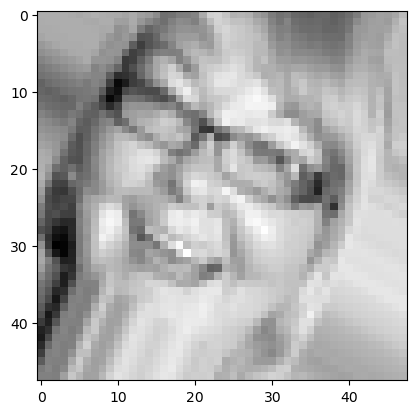

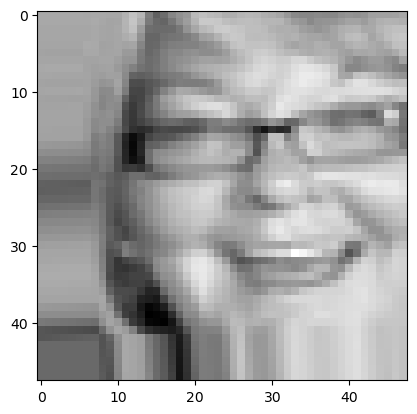

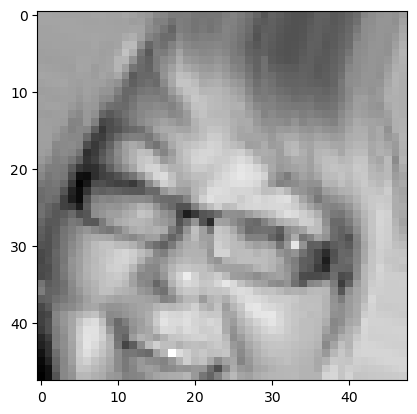

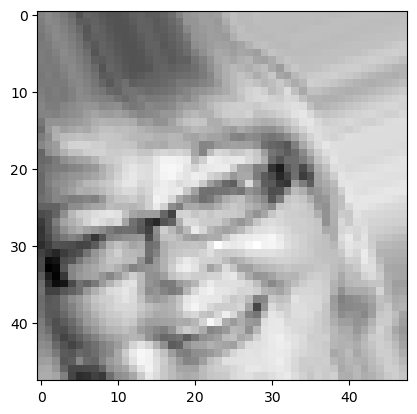

In [3]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

train_happy_dir = os.path.join(train_dir, 'happy')

fnames = [os.path.join(train_happy_dir, fname) for fname in os.listdir(train_happy_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_width, img_height))

# Convert it to a Numpy array with shape (48, 48, 3)
x = image.img_to_array(img)

# Reshape it to (1, 48, 48, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in train_datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

In [4]:
# Generate batches of image data (train and validation)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 14357 images belonging to 7 classes.
Found 14352 images belonging to 7 classes.


Del notebook "SEarchCNNStructure" pudimos encontrar que la estructura de CNN óptima era la del Trial 63. A continuación se muestran los parámetros de la estructura óptima encontrada:

Trial 153 summary

Hyperparameters:

conv_filters_1: 16
conv_kernel_1: 3
num_conv_layers: 3
conv_filters_2: 128
conv_kernel_2: 5
num_dense_layers: 2
dense_units_1: 256
conv_filters_3: 128
conv_kernel_3: 3
conv_filters_4: 128
conv_kernel_4: 5
conv_filters_5: 128
conv_kernel_5: 5
conv_filters_6: 96
conv_kernel_6: 5
dense_units_2: 32
dense_units_3: 128
dense_units_4: 32
conv_filters_7: 16
conv_kernel_7: 3
Score: 0.5441053509712219

## CNN From scratch 

In [5]:
# Define the CNN model
# Vamos a tener: 4 capas convolucionales (intercaladas con capas MaxPooling) y 3 capas densas (la última con units = nºclases de los datos --> 7)

model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(img_width, img_height, 3), padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(128, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

model.add(layers.Conv2D(128, (5,5), activation='relu', padding='same'))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding='same'))

# Flatten layer
model.add(layers.Flatten())

#Añadimos dropout
model.add(layers.Dropout(0.5))

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(32, activation='relu'))

# Output layer
model.add(layers.Dense(7, activation='softmax'))  # 7 output classes (emotions)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       51328     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [7]:
# Compile the model
from keras import callbacks
num_epochs = 200
earlystopping = callbacks.EarlyStopping(monitor="val_accuracy",
                                        patience=10,
                                        restore_best_weights=True)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[earlystopping]
)

model.save('model_DataAug.h5')


Epoch 1/200
224/224 [==============================] - 19s 67ms/step - loss: 1.8230 - accuracy: 0.2475 - val_loss: 1.8117 - val_accuracy: 0.2513
Epoch 2/200
224/224 [==============================] - 12s 52ms/step - loss: 1.8093 - accuracy: 0.2512 - val_loss: 1.7988 - val_accuracy: 0.2542
Epoch 3/200
224/224 [==============================] - 11s 51ms/step - loss: 1.7988 - accuracy: 0.2493 - val_loss: 1.7945 - val_accuracy: 0.2515
Epoch 4/200
224/224 [==============================] - 11s 51ms/step - loss: 1.7883 - accuracy: 0.2562 - val_loss: 1.7822 - val_accuracy: 0.2563
Epoch 5/200
224/224 [==============================] - 11s 51ms/step - loss: 1.7877 - accuracy: 0.2535 - val_loss: 1.7664 - val_accuracy: 0.2706
Epoch 6/200
224/224 [==============================] - 11s 50ms/step - loss: 1.7819 - accuracy: 0.2601 - val_loss: 1.7789 - val_accuracy: 0.2584
Epoch 7/200
224/224 [==============================] - 11s 51ms/step - loss: 1.7729 - accuracy: 0.2617 - val_loss: 1.7434 - val_ac

In [8]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("\nTest accuracy:", test_acc)

Found 7178 images belonging to 7 classes.
113/113 - 2s - loss: 1.1444 - accuracy: 0.5663 - 2s/epoch - 20ms/step

Test accuracy: 0.5663137435913086


In [9]:
df_history = pd.DataFrame(history.history)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,1.823001,0.247464,1.811718,0.251325
1,1.809330,0.251242,1.798765,0.254185
2,1.798844,0.249283,1.794474,0.251465
3,1.788266,0.256209,1.782192,0.256278
4,1.787683,0.253481,1.766380,0.270647


<Axes: title={'center': 'Losses'}, xlabel='Epochs', ylabel='Loss'>

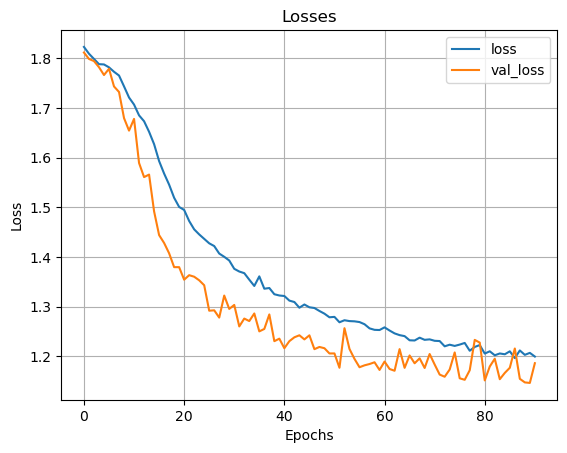

In [10]:
df_history['loss'].plot(legend=True)
df_history['val_loss'].plot(title='Losses', grid=True,
                              xlabel='Epochs',
                              ylabel='Loss',
                              legend=True)

<Axes: title={'center': 'Accuracies'}, xlabel='Epochs', ylabel='Accuracy'>

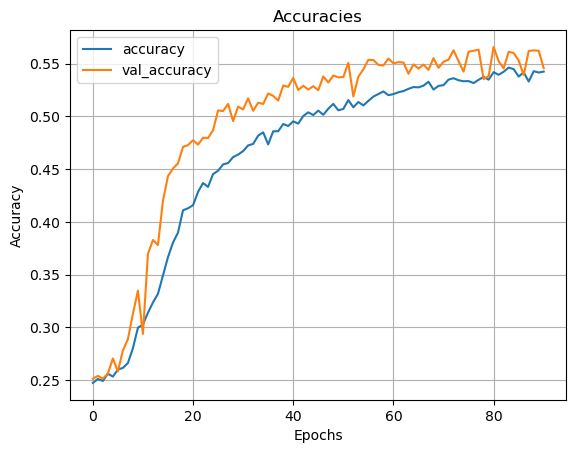

In [11]:
df_history['accuracy'].plot(legend=True)
df_history['val_accuracy'].plot(title='Accuracies', grid=True,
                              xlabel='Epochs',
                              ylabel='Accuracy',
                              legend=True)